In [1]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))

import numpy as np
import sklearn
import torch
from loguru import logger

from src.data import DataLoader, DataPreprocessor, FeatureEngineer
from sklearn.model_selection import train_test_split
from src.models import LogReg, NeuralNet, RandomForest
from src.visualization import DataExplorer, ResultsExplorer

In [2]:
# get cli args
use_dependencies = "use-dependencies" in sys.argv
visualize_data = "skip-visualization" not in sys.argv
log_level = (
    sys.argv[sys.argv.index("--log-level") + 1] if "--log-level" in sys.argv else "INFO"
)
path_data_train = (
    sys.argv[sys.argv.index("--path-data-train") + 1]
    if "--path-data-train" in sys.argv
    else "data/raw/train.csv"
)
path_data_test = (
    sys.argv[sys.argv.index("--path-data-test") + 1]
    if "--path-data-test" in sys.argv
    else "data/raw/test.csv"  #
)

# set seeds
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
sklearn.utils.check_random_state(seed_value)

# configure logging
# logger.remove(0)
# logger.add(sys.stderr, level=log_level.upper())

# log config vars
logger.info(f"log-level: {log_level.upper()}")
logger.info(f"visualize-data: {visualize_data}")
logger.info(f"use-dependencies: {use_dependencies}")
logger.info(f"path-data-train: {path_data_train}")
logger.info(f"path-data-test: {path_data_test}\n")

2024-06-17 15:48:53.143 | INFO     | __main__:<module>:30 - log-level: INFO
2024-06-17 15:48:53.143 | INFO     | __main__:<module>:31 - visualize-data: True
2024-06-17 15:48:53.144 | INFO     | __main__:<module>:32 - use-dependencies: False
2024-06-17 15:48:53.144 | INFO     | __main__:<module>:33 - path-data-train: data/raw/train.csv
2024-06-17 15:48:53.145 | INFO     | __main__:<module>:34 - path-data-test: data/raw/test.csv



In [3]:
# load data
data_loader = DataLoader()

data_train_raw = data_loader.load_data(base_path / path_data_train)
data_test_raw = data_loader.load_data(
    base_path / path_data_test
)  # no target given in test set

2024-06-17 15:48:53.188 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.

2024-06-17 15:48:53.191 | SUCCESS  | src.data.data_loader:load_data:14 - Successfully created Pandas Dataframe from raw data.



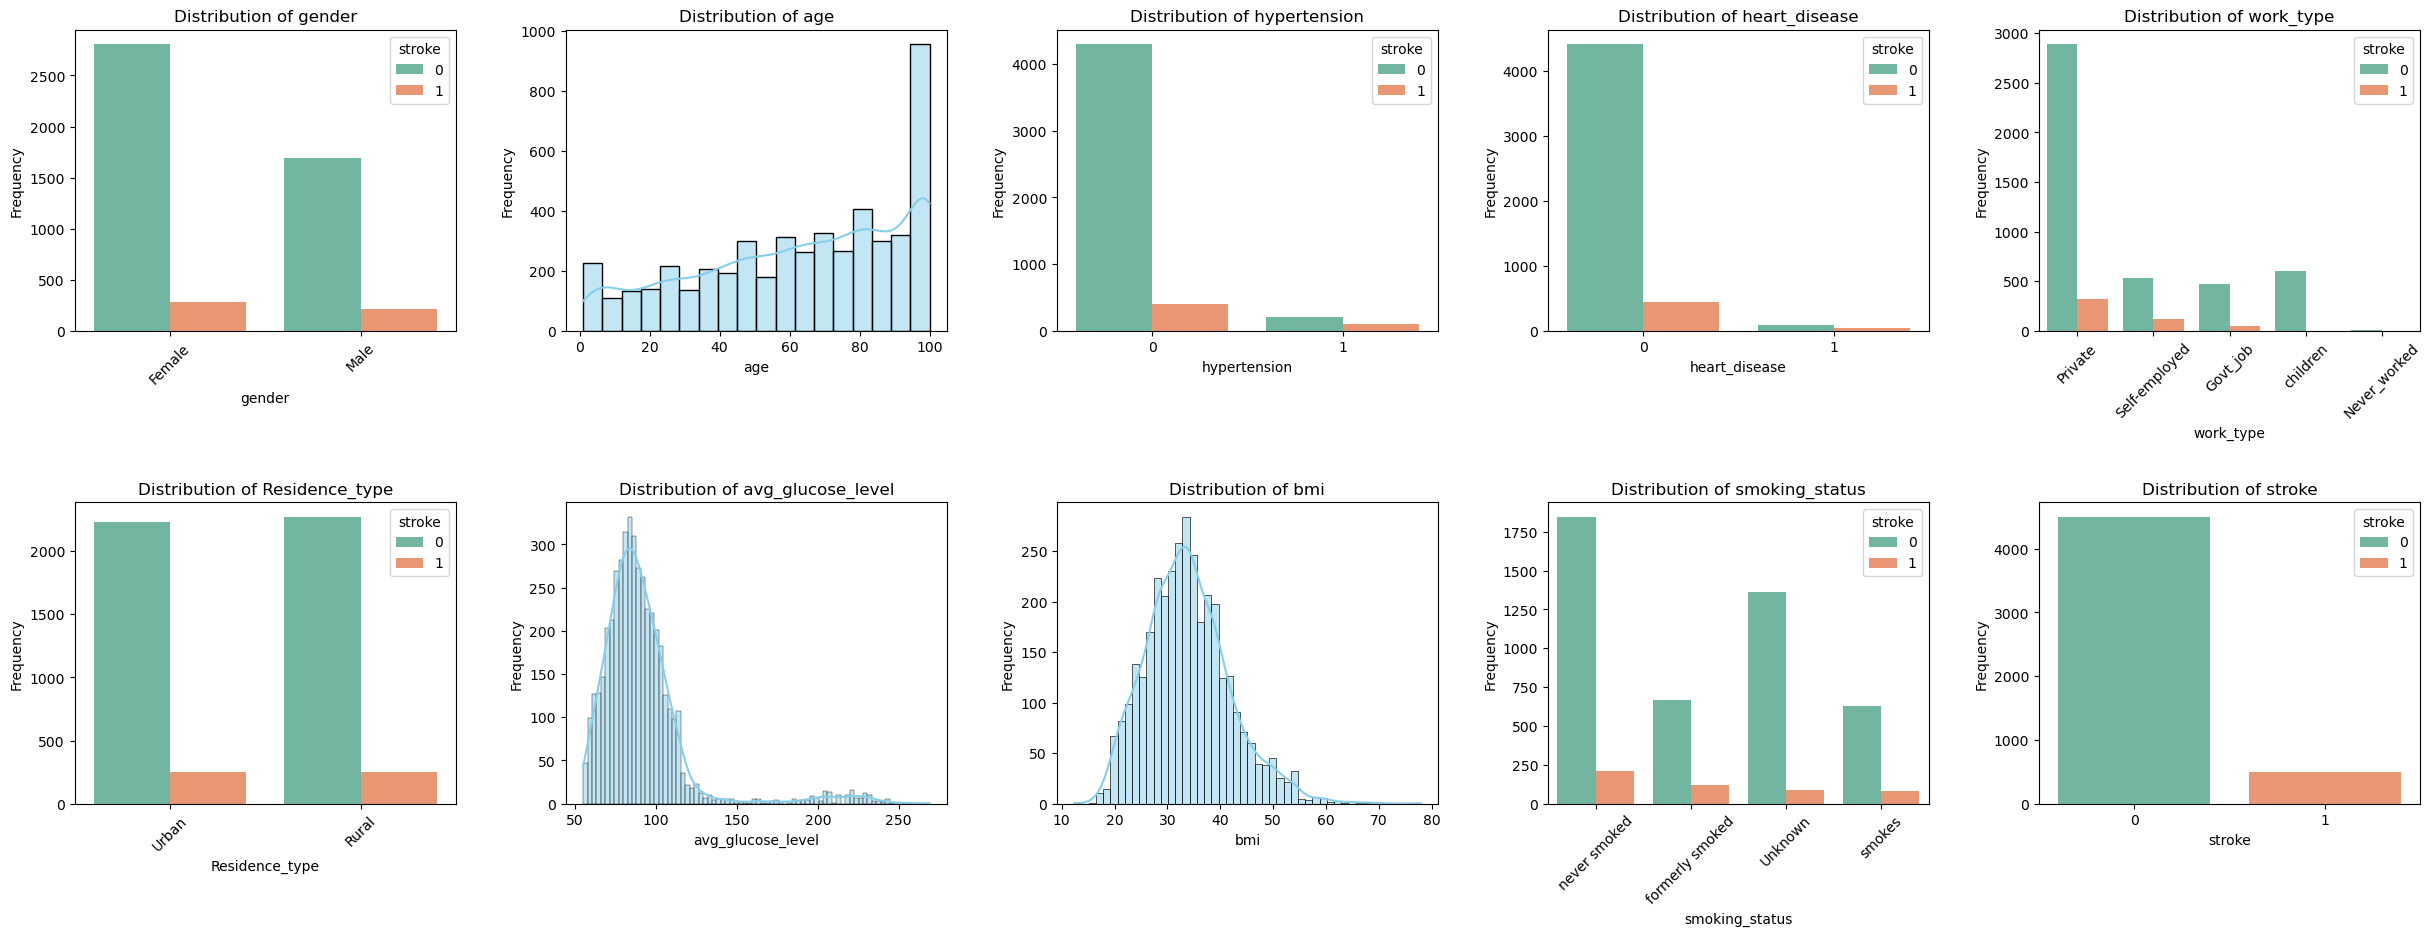

2024-06-17 15:48:54.483 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column id: 0 / 5000
2024-06-17 15:48:54.485 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column gender: 0 / 5000
2024-06-17 15:48:54.486 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column age: 0 / 5000
2024-06-17 15:48:54.487 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column hypertension: 0 / 5000
2024-06-17 15:48:54.487 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column heart_disease: 0 / 5000
2024-06-17 15:48:54.488 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column work_type: 0 / 5000
2024-06-17 15:48:54.490 | INFO     | src.visualization.data_explorer:plot_nans:61 - Number of NaN values in column Residence_type: 0 / 5000
2024-06-17 15:48:54.491 | INFO     | src.visualization.data

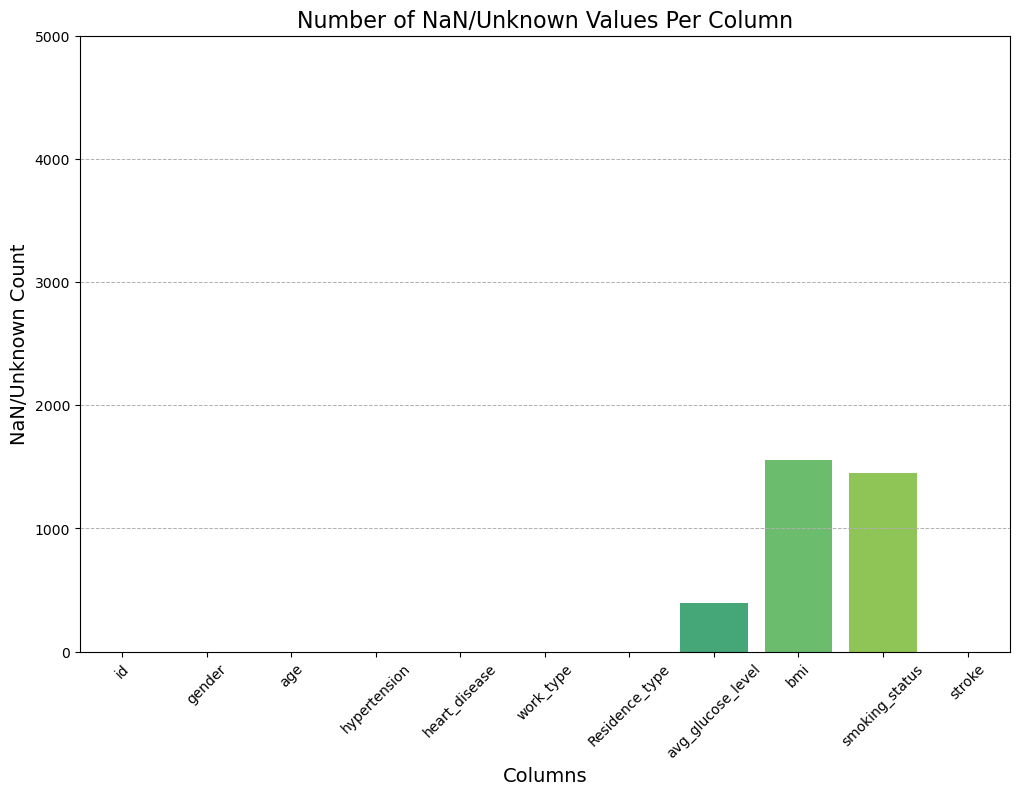

In [4]:
# visualize raw data
if visualize_data:
    data_explorer = DataExplorer()
    data_explorer.plot_distributions(data_train_raw)
    data_explorer.plot_nans(data_train_raw)
    # data_explorer.print_non_numericals(data_train_raw)

In [5]:
# preprocess data
data_preprocessor = DataPreprocessor()
data_train_preprocessed = data_preprocessor.transform_non_numericals(data_train_raw)
data_test_preprocessed = data_preprocessor.transform_non_numericals(data_test_raw)
# data_train_preprocessed = data_preprocessor.remove_nans(data_train_raw)

2024-06-17 15:48:54.667 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-17 15:48:54.672 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-17 15:48:54.673 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-17 15:48:54.677 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed smoking_status into one-hot encoding
2024-06-17 15:48:54.678 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed gender into binary encoding
2024-06-17 15:48:54.680 | INFO     | src.data.data_preprocessor:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-06-17 15:48:54.681 | INFO     | src.data.data_preprocessor:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-06-17 15:48:54.683 | INF

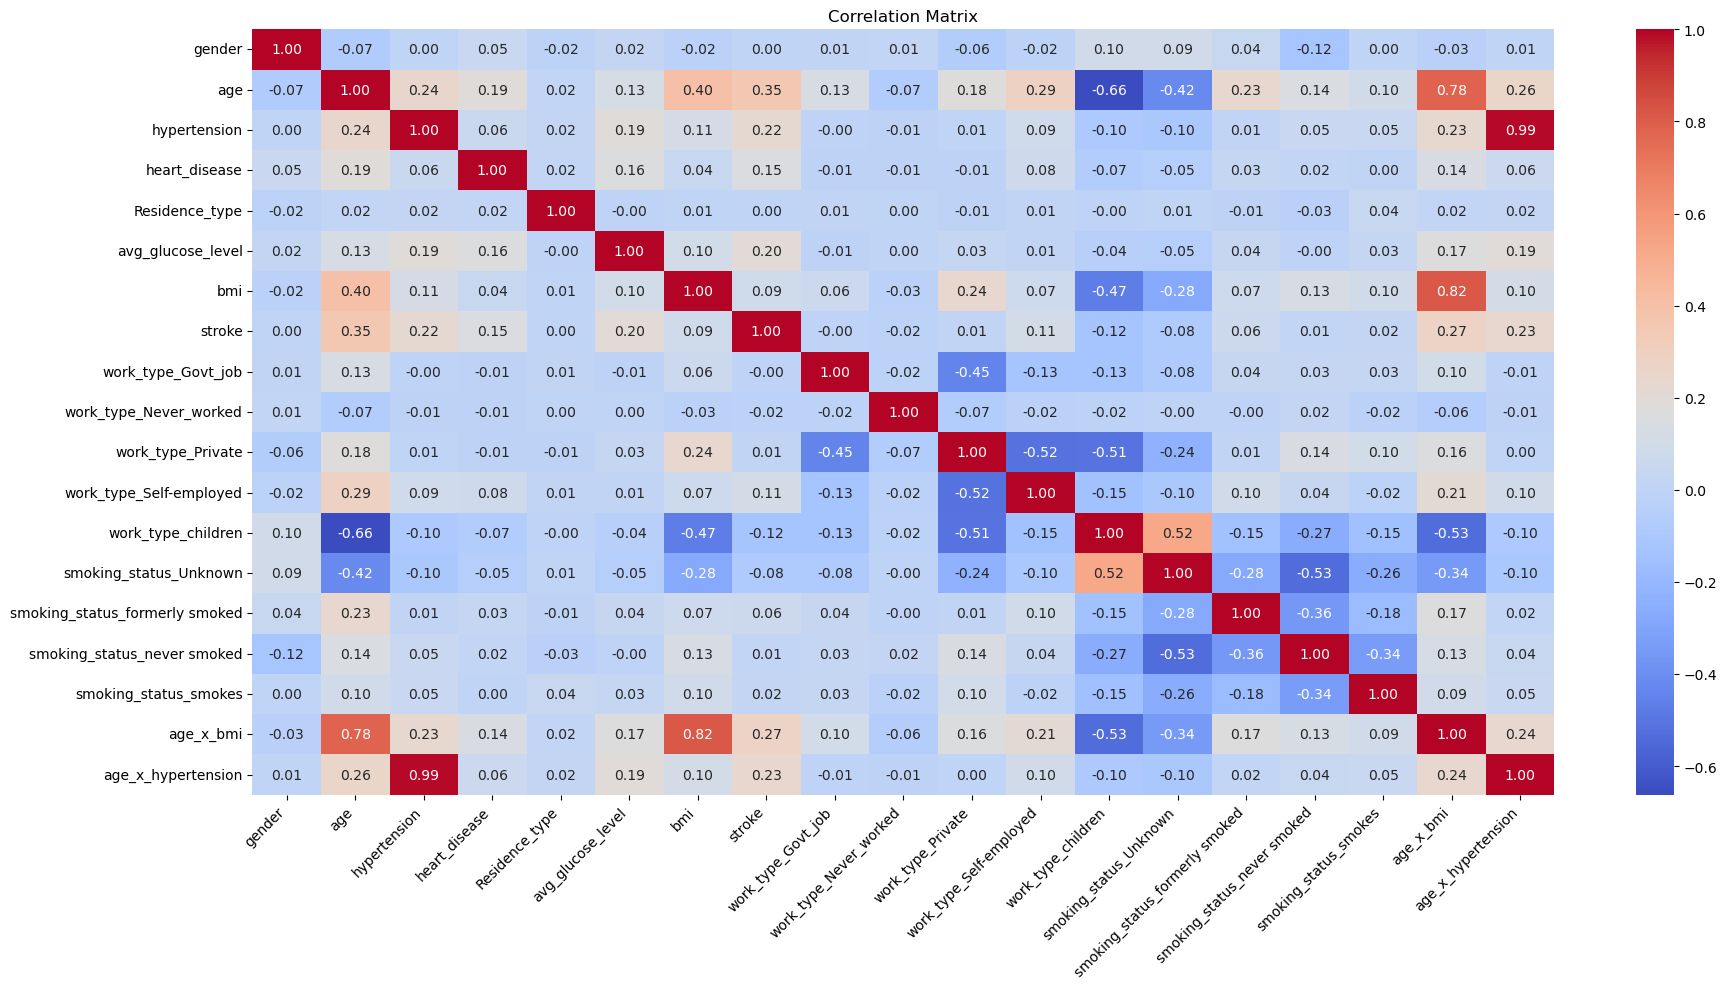

In [33]:
# feature exploration & engineering
feature_engineer = FeatureEngineer(data_train_preprocessed)
data_train_engineered = feature_engineer.drop(
    data_train_preprocessed,
    [
        "id",
        # "Residence_type",
        # "work_type_Private",
        # "work_type_Govt_job",
        # "work_type_Never_worked",
        # "smoking_status_never smoked",
        # "smoking_status_smokes",
        # "smoking_status_Unknown",
    ],
)
data_train_engineered = feature_engineer.dropna(data_train_engineered)
data_train_engineered = feature_engineer.normalize_features(data_train_engineered)

# data_train_engineered = feature_engineer.combine_features(
#     data_train_engineered,
#     [["age", "bmi"], ["age", "hypertension"]],
#     "multiplicative",
# )
if visualize_data:
    data_explorer.plot_correlation_matrix(data_train_engineered)
# data_test_engineered = feature_engineer.apply_transformations(data_test_preprocessed)

In [39]:
X_train, y_train = feature_engineer.split_X_y(data_train_engineered)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# initialize models
log_reg = LogReg(use_dependencies=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
y_pred_proba = log_reg.predict_proba(X_val)
log_reg.evaluate(y_val, y_pred, y_pred_proba)
print(len(y_train))

2024-06-17 16:01:45.378 | INFO     | src.models.base_model:evaluate:43 - Accuracy: 0.750788643533123, F1 score: 0.427536231884058, Precision: 0.28640776699029125, Recall: 0.8428571428571429, AUC: 0.8724417426545086


2535
